<a href="https://colab.research.google.com/github/ziatdinovmax/GPim/blob/master/examples/notebooks/GP_BEPFM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gaussian Process Regression Applied to Hyperspectral Data from BE-PFM Experiments

Prepared by Maxim Ziatdinov (October 2019)

Email: ziatdinovmax@gmail.com

This notebook demonstates application of Gaussian process regression to reconstruction of (artificially corrupted) BE-PFM hyperspecral data and to a sample exploration based on uncertainty.

---
**Important:** For the best performance, please run this notebook with the latest generation GPUs, such as Nvidia's Tesla P100 and Tesla V100. You can get those GPUs in a cloud by [connecting](https://blog.kovalevskyi.com/gce-deeplearning-images-as-a-backend-for-google-colaboratory-bc4903d24947) this Colab notebook to a [Deep Learning VM](https://cloud.google.com/deep-learning-vm/) on Google Cloud Platform. It is also possible to run this notebook in Google Colab hosted runtime with (free) Tesla K80 or Tesla T4 GPUs but the computational time will be significantly longer.


---



Check your cloud GPU:

In [0]:
!nvidia-smi

Tue Feb 18 20:58:27 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P0    44W / 250W |   7295MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
#@title Import/Install/Download { form-width: "20%" }
# install GPim package
!pip install -q git+https://github.com/ziatdinovmax/GPim.git
# import modules
import os
import copy
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from gpim import gpr, gprutils
import torch
import pyro
pyro.set_rng_seed(0)
torch.set_default_tensor_type(torch.DoubleTensor)
# download training data
!wget -qq -O 'BEPFM image_0001 - 128 x 128.h5' 'https://github.com/ziatdinovmax/GPim/blob/master/test_data/BEPFM%20image_0001%20-%20128%20x%20128.h5?raw=true'

In [0]:
#@title Helper functions { form-width: "20%" }

def print_attrs(name, obj):
    print(name)
    for k, v in obj.attrs.items():
        print("  {}: {}".format(k, v))

def inspect_dataset(hf, **kwargs):
    hf.visititems(print_attrs)
    return

def get_raw_data(hf, measurement='Measurement_000', channel='Channel_000'):
    raw_data = hf[measurement+'/'+channel+'/Raw_Data'][:]
    return raw_data

def get_dims(hf, measurement='Measurement_000'):
    cols = hf[measurement].attrs['grid_num_cols']
    rows = hf[measurement].attrs['grid_num_rows']
    bins = hf[measurement].attrs['num_bins']
    return cols, rows, bins 

def get_spectr_info(hf, measurement='Measurement_000', channel='Channel_000'):
    spec_values = hf[measurement+'/'+channel+'/Spectroscopic_Values'][:]
    spec_units = hf[measurement+'/'+channel+'/Spectroscopic_Indices'].attrs['units']
    spec_label = hf[measurement+'/'+channel+'/Spectroscopic_Indices'].attrs['labels']
    return spec_values, spec_units[0].decode('utf-8'), spec_label[0].decode('utf-8')

### Review dataset(s)

Select a file to work with and print the hdf5 file data tree:

In [0]:
datadir = './'
filename = 'BEPFM image_0001 - 128 x 128.h5'

hf = h5py.File(os.path.join(datadir, filename), 'r')
inspect_dataset(hf)

Measurement_000
  num_bins: 102
  num_pix: 16384
  num_steps: 1
  num_UDVS_bins: 102
  data_type: b'BELineData'
  VS_mode: b'none'
  BE_phase_content: b'chirp-sinc hybrid'
  AFM_XLVDT_sensor: 4.2214e-06
  AFM_YLVDT_sensor: 4.3626e-06
  AFM_ZLVDT_sensor: 4.790395e-06
  AFM_XPiezo_sensitivity: -1.7437e-07
  AFM_YPiezo_sensitivity: 1.8489e-07
  AFM_ZPiezo_sensitivity: 2.95923e-08
  AFM_InvOLS: 1e-07
  grid_num_cols: 128
  grid_num_rows: 128
  grid__scan_rate_[Hz]: 0.95367431640625
  grid__set-point_[V]: 1.0
  IO_AFM_platform: b'Cypher'
  IO_card: b'6124'
  IO_rate: 4000000.0
  IO_AO_range: 10.0
  IO_AI_range: 10.0
  IO_analog_output_amplifier_ring: 1.0
  IO_deflection_detector_ring: 0
  IO_sensitivity: 1.0
  IO_Channel_001_type: b'none'
  IO_Channel_002_type: b'none'
  IO_Channel_003_type: b'none'
  BE_signal_type_ring: 1.0
  BE_band_width_[Hz]: 50000.0
  BE_center_frequency_[Hz]: 323000.0
  BE_amplitude_[V]: 2.0
  BE_phase_variation: 1.0
  BE_repeats: 1.0
  BE_auto_smooth_cond: 1.0
  BE_

Get the raw data and reshape it:

In [0]:
raw_data = get_raw_data(hf, measurement='Measurement_000', channel='Channel_000')
print('data dimensions: {}'.format(raw_data.shape))
raw_data = raw_data.reshape(get_dims(hf, measurement='Measurement_000'))
raw_data = np.abs(raw_data).astype(np.float64)
print('reshaped data dimensions: {}'.format(raw_data.shape))
#hf.close()

data dimensions: (16384, 102)
reshaped data dimensions: (128, 128, 102)


Plot selected slices of hyperspectral cube and individual spectroscopic curves:

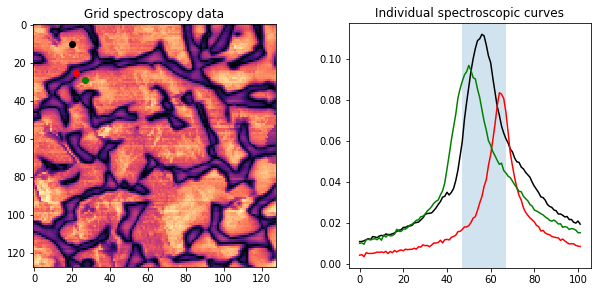

In [0]:
# choose slice
slice_number = 57
spectral_window = 10
# select cooordinates for individual spectroscopic curves
pos = [
       [10, 20], 
       [25, 22], 
       [29, 27],
]
# Plotting
gprutils.plot_raw_data(raw_data, slice_number, pos, spectral_window)

## Prepare data

Take part of data (for testing purposes):

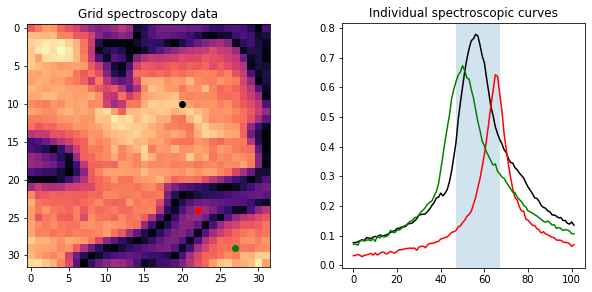

In [0]:
# define crop size
x_start, x_end = 0, 32
y_start, y_end = 0, 32
z_start, z_end = 0, 102
x_res, y_res, z_res = 1, 1, 1
# adjust manually if necessary
pos = [
       [10, 20], 
       [24, 22], 
       [29, 27],
]
# crop and plot
R_true = raw_data[x_start:x_end:x_res, y_start:y_end:y_res, z_start:z_end:z_res]
R_true = (R_true - np.amin(R_true))/np.ptp(R_true)
gprutils.plot_raw_data(R_true, slice_number, pos, spectral_window)

Now we corrupt data by removing certain percentage of the observations:

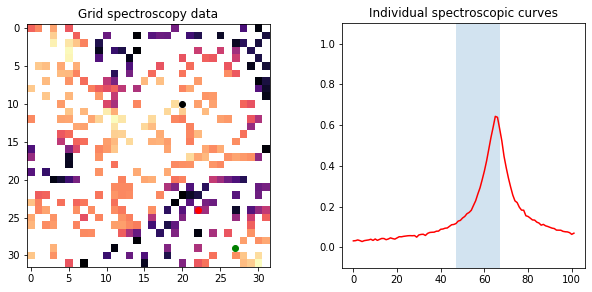

In [0]:
remove_obs = 0.7 # remove 70 % of the data

# Store "true" grid indices before removing parts of the data
e1, e2, e3 = R_true.shape
c1, c2, c3 = np.mgrid[:e1:1., :e2:1., :e3:1.]
X_true = np.array([c1, c2, c3])
# Remove observations and plot the new "corrupted" data
X, R = gprutils.corrupt_data_xy(X_true, R_true, prob=remove_obs)
gprutils.plot_raw_data(R, slice_number, pos, spectral_window, norm=True)

## Gaussian Process Regression Analysis

We now run GP regression on the corrupted data to reconstruct the original signal:

In [0]:
#@title GP regression: model training and prediction (select parameters and click 'Run') { form-width: "50%" }
KERNEL = "Matern52" #@param ["RationalQuadratic", "RBF", "Matern52"]
LENGTH_CONSTR_MIN = 1 #@param {type:"slider", min:1, max:100, step:0.5}
LENGTH_CONSTR_MAX = 20 #@param {type:"slider", min:5, max:100, step:0.5}
LEARNING_RATE = 0.1 #@param {type:"slider", min:0.0005, max:0.1, step:0.0005}
STEPS = 500 #@param {type:"slider", min:100, max:10000, step:100}
INDUCING_POINTS = 1000 #@param {type:"slider", min:20, max:10000, step:10}
USE_GPU = True #@param ["True", "False"] {type:"raw"}

LENGTH_CONSTR = [
                 [float(LENGTH_CONSTR_MIN) for i in range(3)],
                 [float(LENGTH_CONSTR_MAX) for i in range(3)]
]

reconstr = gpr.reconstructor(
    X, R, X_true, KERNEL, LENGTH_CONSTR, INDUCING_POINTS,
    LEARNING_RATE, STEPS, use_gpu=USE_GPU, verbose=True
)
mean, sd, hyperparams = reconstr.run()

# of inducing points for GP regression: 1024
Model training...
iter: 0 ... loss: 56663.2848 ... amp: 8.6959 ... length: [ 8.3244 17.3963  3.7983] ... noise: 1.1051709 ...
iter: 100 ... loss: -46651.0652 ... amp: 0.3708 ... length: [11.992  19.4961 16.8076] ... noise: 0.0024521 ...
average time per iteration: 0.20989999999999998 s
iter: 200 ... loss: -60869.3536 ... amp: 0.0098 ... length: [ 3.1141  4.8867 18.5363] ... noise: 0.0006715 ...
iter: 300 ... loss: -61517.9384 ... amp: 0.0093 ... length: [ 3.0594  4.687  18.3503] ... noise: 0.0006241 ...
iter: 400 ... loss: -61795.1553 ... amp: 0.0086 ... length: [ 2.9798  4.5828 18.0372] ... noise: 0.0006044 ...
iter: 499 ... loss: -61954.7609 ... amp: 0.0079 ... length: [ 2.8969  4.4404 17.6025] ... noise: 0.0005922 ...
training completed in 103.73 s
Final parameter values:
 amp: 0.0079, lengthscale: [ 2.8969  4.4404 17.6025], noise: 0.0005922
Calculating predictive mean and variance... Done


Plot the evolution of hyperparameters during the training:

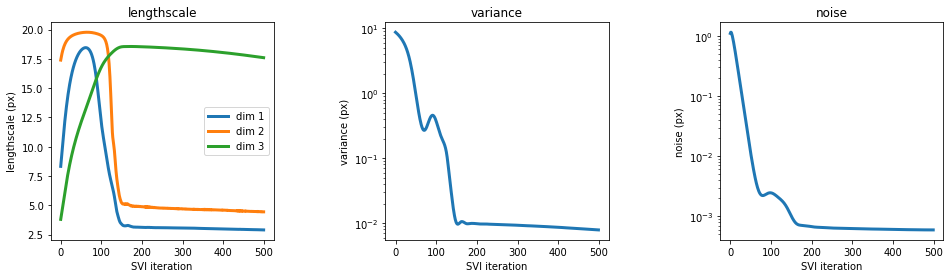

In [0]:
gprutils.plot_kernel_hyperparams(hyperparams)

Plot the evolution of inducing points:

(may take up to ~1 minute)

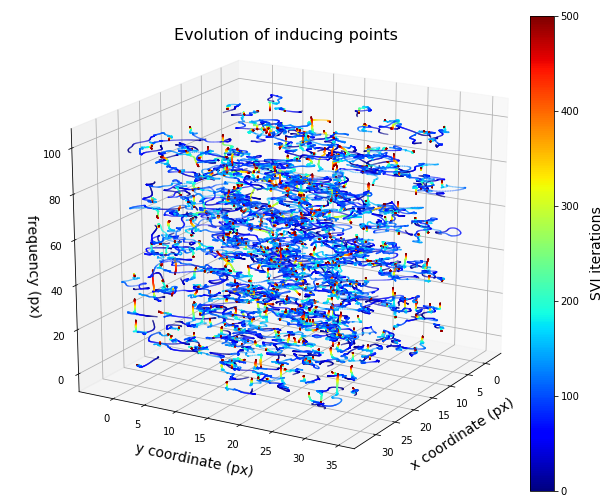

In [0]:
gprutils.plot_inducing_points(hyperparams, slice_step=2)

Plot the results:

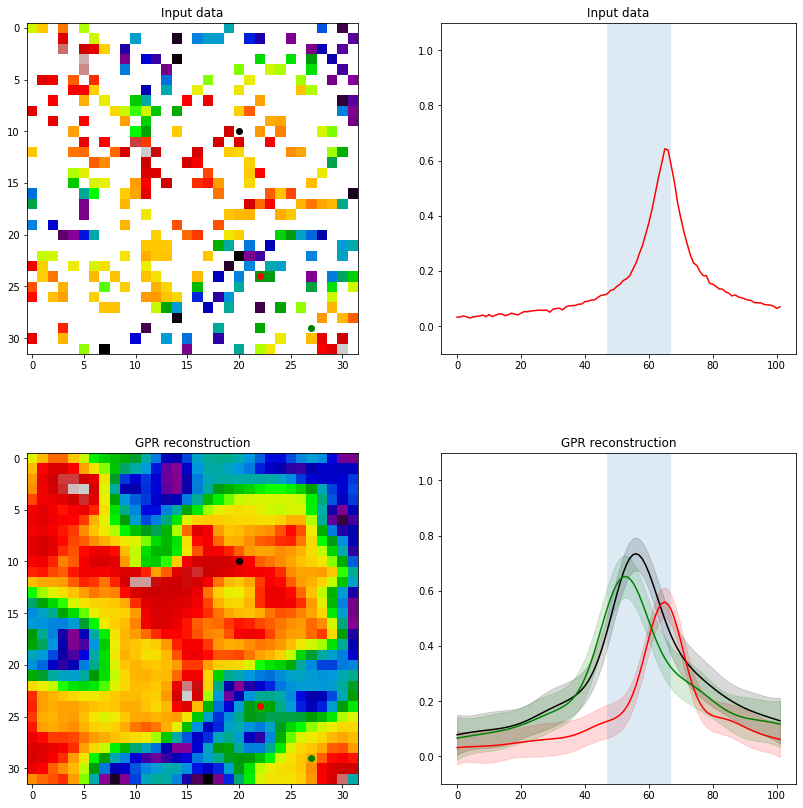

In [0]:
gprutils.plot_reconstructed_data3d(R, mean, sd, slice_number, pos, spectral_window)

## Sample exploration with GP regression

We are now going to expore our "sample" in the iterative fashion:
Use GPR to reconstruct data from initial "observations" --> do "measurement" in the point with maximum uncertainty (as estimated from GPR) --> Add the new "measured" points to the initial points --> repeat.

Prepare data:

In [0]:
# define crop size
x_start, x_end = 0, 32
y_start, y_end = 0, 32
z_start, z_end = 0, 102
x_res, y_res, z_res = 1, 1, 1
# get the subset of data
R_true = raw_data[x_start:x_end:x_res, y_start:y_end:y_res, z_start:z_end:z_res]
R_true = (R_true - np.amin(R_true))/np.ptp(R_true)
e1, e2, e3 = R_true.shape
c1, c2, c3 = np.mgrid[:e1:1., :e2:1., :e3:1.]
X_true = np.array([c1, c2, c3])
# Let's start with "measuring" several points along each edge
R = R_true*0
R[R==0] = np.nan
R = gprutils.open_edge_points(R, R_true)
X, R = gprutils.corrupt_data_xy(X_true, R)

Run the analysis. We are going to increase a learning rate while decreasing a number of SVI steps in each iteration to see how fast we can discover new things in the "sample".

(notice that the size of a measurement square is defined as 2*M+1, so that M=0 corresponds to a doing a single measurement)

In [0]:
#@title GP exploration (select parameters and click 'Run') { form-width: "40%" }
EXPLORATION_STEPS = 100 #@param {type:"slider", min:1, max:300, step:1}
MEASUREMENT_AREA = 0 #@param {type:"slider", min:0, max:5, step:1}
KERNEL = "Matern52" #@param ["RationalQuadratic", "RBF", "Matern52"]
LENGTH_CONSTR_MIN = 1 #@param {type:"slider", min:1, max:100, step:0.5}
LENGTH_CONSTR_MAX = 20 #@param {type:"slider", min:5, max:100, step:0.5}
LEARNING_RATE = 0.1 #@param {type:"slider", min:0.0005, max:0.1, step:0.0005}
STEPS = 500 #@param {type:"slider", min:100, max:10000, step:100}
DISTANCE_EDGE = 0 #@param {type:"slider", min:0, max:10, step:1}
USE_GPU = True #@param ["True", "False"] {type:"raw"}
SAVE_DIR = "Output" #@param {type:"string"}

LENGTH_CONSTR = [
                 [float(LENGTH_CONSTR_MIN) for i in range(3)],
                 [float(LENGTH_CONSTR_MAX) for i in range(3)]
]
DIST_EDGE = [DISTANCE_EDGE, DISTANCE_EDGE]
MSIZE = MEASUREMENT_AREA

# Run exploratory analysis
uncert_idx_all, uncert_val_all, mean_all, sd_all, R_all = [], [], [], [], []
if not os.path.exists(SAVE_DIR): os.makedirs(SAVE_DIR)
for i in range(EXPLORATION_STEPS):
    print('Exploration step {}/{}'.format(i, EXPLORATION_STEPS))
    # Make the number of inducing points dependent on the number of datapoints
    indpoints = len(gprutils.prepare_training_data(X, R)[0]) // 20
    # Initialize explorer
    bexplorer = gpr.reconstructor(
        X, R, X_true, KERNEL, LENGTH_CONSTR, indpoints,
        LEARNING_RATE, STEPS, use_gpu=USE_GPU, verbose=False)
    # get indices/value of a max uncertainty point
    uncert_idx, uncert_val, mean, sd = bexplorer.step(DIST_EDGE)
    # some safeguards (to not stuck at one point)
    uncert_idx, uncert_val = gprutils.checkvalues(
        uncert_idx, uncert_idx_all, uncert_val)
    # store intermediate results 
    uncert_idx_all.append(uncert_idx)
    uncert_val_all.append(uncert_val)
    R_all.append(copy.deepcopy(R.flatten()))
    mean_all.append(copy.deepcopy(mean))
    sd_all.append(copy.deepcopy(sd))
    # make a "measurement" in the point with maximum uncertainty
    print('Doing "measurement"...\n')
    R, X = gprutils.do_measurement(
        R_true, X_true, R, X, uncert_idx, MSIZE)
    # (over)write results on disk
    np.save(os.path.join(
        SAVE_DIR, 'sgpr_bepfm_R_4.npy'), R_all)
    np.save(os.path.join(
        SAVE_DIR, 'sgpr_bepfm_means_4.npy'), mean_all)
    np.save(os.path.join(
        SAVE_DIR, 'sgpr_bepfm_sd_4.npy'), sd_all)
    np.save(os.path.join(
        SAVE_DIR, 'sgpr_bepfm_amax_4.npy'), uncert_idx_all)

Exploration step 0/100
# of inducing points for GP regression: 102
Model training...
average time per iteration: 0.020499999999999997 s
training completed in 10.21 s
Final parameter values:
 amp: 0.0124, lengthscale: [11.8228 11.5651 19.0913], noise: 0.0007471
Calculating predictive mean and variance... Done
Maximum uncertainty of 9.33828307552715 at [15, 15]
Doing "measurement"...

Exploration step 1/100
# of inducing points for GP regression: 108
Model training...
average time per iteration: 0.0218 s
training completed in 10.4 s
Final parameter values:
 amp: 0.0107, lengthscale: [11.3547 11.1172 18.6991], noise: 0.0007469
Calculating predictive mean and variance... Done
Maximum uncertainty of 6.283950216232884 at [21, 21]
Doing "measurement"...

Exploration step 2/100
# of inducing points for GP regression: 113
Model training...
average time per iteration: 0.0219 s
training completed in 10.35 s
Final parameter values:
 amp: 0.0114, lengthscale: [11.4804 11.5328 18.8856], noise: 0.000

Plot the results:

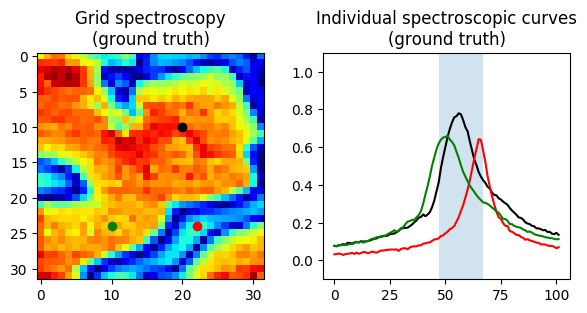

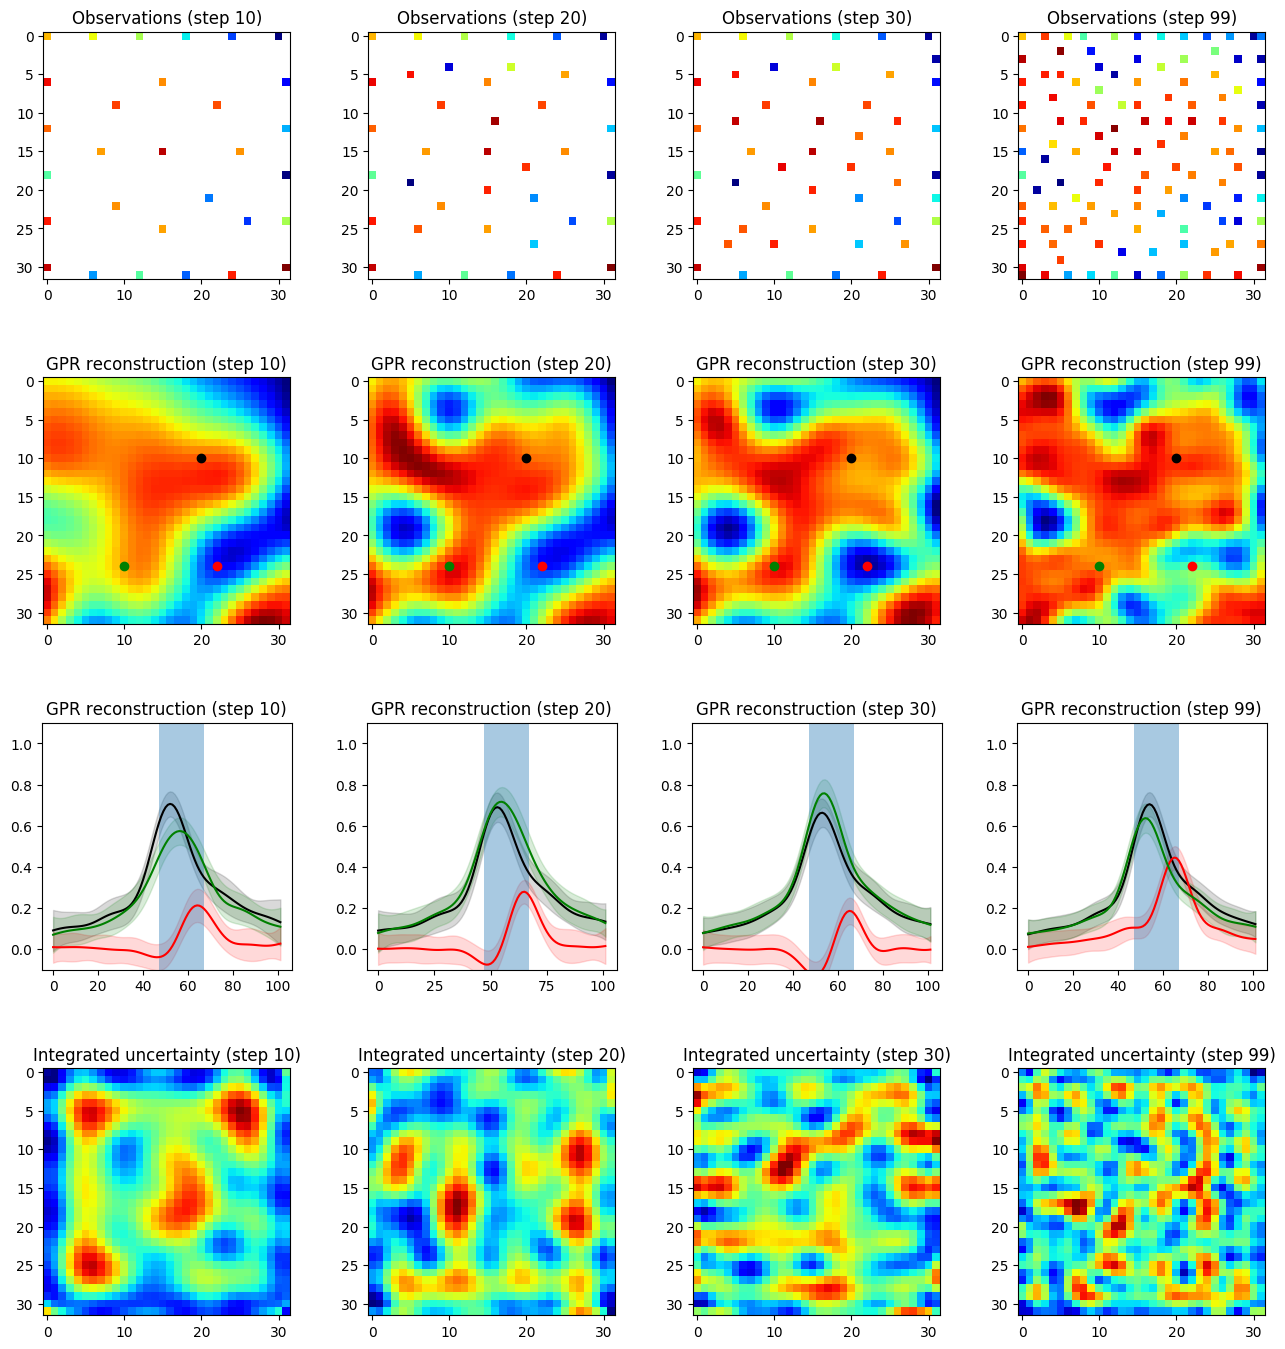

In [0]:
steps = [10, 20, 30, 99] # view results at these exploration steps
pos = [
       [10, 20], 
       [24, 22], 
       [24, 10],
]
slice_number = 57
spec_window = 10
dist_edge = DIST_EDGE

gprutils.plot_exploration_results(
    R_all, mean_all, sd_all, R_true, steps,
    slice_number, pos, dist_edge, spec_window)

Plot the exploration path in the *xy* space:

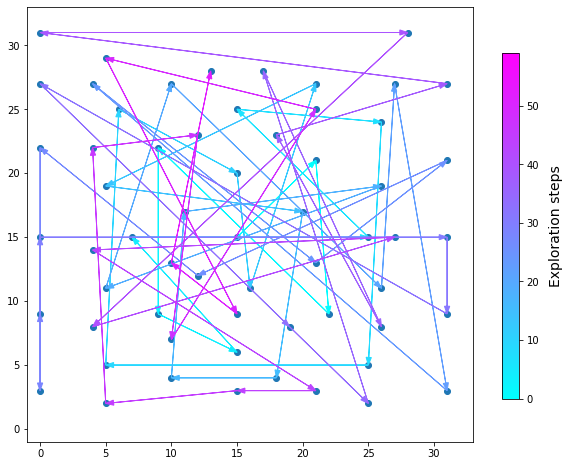

In [0]:
n_points = 60
colormap = cm.cool
gp_points = np.array(uncert_idx_all)
colorst = [colormap(i) for i in np.linspace(0, 0.9, n_points)]
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.set_xlim(-1, 33)
ax.set_ylim(-1, 33)
for j in range(n_points-1):
    x, y = gp_points[j] 
    dx = gp_points[j+1][0] - x
    dy = gp_points[j+1][1] - y
    ax.arrow(y, x, dy, dx, length_includes_head=True, head_width=0.4, color=colorst[j])
plt.scatter(gp_points[:n_points, 1], gp_points[:n_points, 0])
clrbar = np.linspace(0, n_points-1).reshape(-1, 1)
ax2 = fig.add_axes([.78, .1, .2, .8])
img = plt.imshow(clrbar, colormap)
plt.gca().set_visible(False)
clrbar_ = plt.colorbar(img, ax=ax2, orientation='vertical')
clrbar_.set_label('Exploration steps', fontsize=14, labelpad=10)
plt.show()

We can also quickly calculate and plot integrated absolute error versus exploration steps:

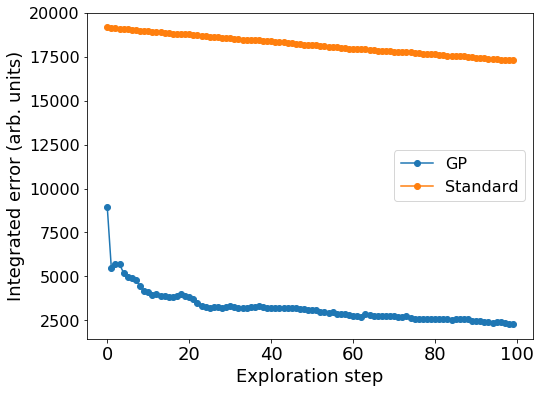

In [0]:
e1, e2, e3 = R_true.shape
R_true_masked = gprutils.mask_edges(np.sum(R_true, -1), DIST_EDGE)
sum_error_gp, sum_error_stand = [], []
for i in range(EXPLORATION_STEPS):
    mean_i = gprutils.mask_edges(
        np.sum(mean_all[i].reshape(e1, e2, e3), -1), DIST_EDGE)
    sum_error = np.sum(np.abs(R_true_masked - mean_i))
    partial_img = gprutils.mask_edges(
        np.sum(np.nan_to_num(R_all[i]).reshape(e1, e2, e3), -1), DIST_EDGE)
    sum_error_ = np.sum(np.abs(R_true_masked - partial_img))
    sum_error_gp.append(sum_error)
    sum_error_stand.append(sum_error_)
# plot results
plt.figure(figsize=(8, 6))
plt.plot(sum_error_gp, '-o', label='GP')
plt.plot(sum_error_stand, '-o', label='Standard')
plt.xlabel('Exploration step', fontsize=18)
plt.ylabel('Integrated error (arb. units)', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.show()